<a href="https://colab.research.google.com/github/j-ranasinghe/Electricity-consumption-forecasting/blob/main/Data_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm as tqdm_notebook

In [89]:
cols = ["ACCOUNT_NO","DATE","SALES_TYPE","BILL","UNIT"]
df = pd.read_csv("/content/data/data kelaniya-DESKTOP-CPVCTNE.csv", header=0, names=cols)
file = "/content/data/data kelaniya-DESKTOP-CPVCTNE.csv"

In [90]:
df.head()

,ACCOUNT_NO,DATE,SALES_TYPE,BILL,UNIT
0,207180402,12/1/2022,C,1704.00,84
1,204083110,12/1/2022,C,9840.00,212
2,204083011,12/1/2022,C,12123.43,242
3,204083209,12/1/2022,C,4133.71,119
4,208707807,12/1/2022,C,6120.32,163


In [91]:
df.shape #Check the shape of the dataset

(344051, 5)

In [92]:
df["UNIT"] = df["UNIT"].astype(float)
df["BILL"] = df["BILL"].astype(float)
df["ACCOUNT_NO"] = df["ACCOUNT_NO"].astype(float)

In [93]:
df.dtypes

ACCOUNT_NO    float64
DATE           object
SALES_TYPE     object
BILL          float64
UNIT          float64
dtype: object

In [94]:
df.describe()

,ACCOUNT_NO,BILL,UNIT
count,3.440510e+05,3.440510e+05,344051.000000
mean,2.056564e+08,8.367139e+03,252.687552
std,3.249326e+06,1.026749e+05,3265.513837
min,2.000001e+08,0.000000e+00,-7550.000000
25%,2.028522e+08,7.754000e+02,54.000000
50%,2.056149e+08,2.604000e+03,97.000000
75%,2.085322e+08,5.149860e+03,151.000000
max,2.112482e+08,1.181568e+07,385572.000000


In [95]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["MONTH"] = df["DATE"].dt.month
df["YEAR"] = df["DATE"].dt.year
df = df.sort_values("DATE").drop("DATE", axis=1)


In [96]:
# Extract the values for the "SALES_TYPE" column
Sales_type_data= df['SALES_TYPE'].values
# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder to the sales type data
encoder.fit(Sales_type_data)

# Encode the location data
encoded_sales_type = encoder.transform(Sales_type_data)
df['SALES_TYPE'] =encoded_sales_type

In [97]:
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

In [98]:
df.head()

,ACCOUNT_NO,SALES_TYPE,BILL,UNIT,MONTH,YEAR
172025,210733809.0,0,256.00,17.0,9,2022
174332,203435210.0,0,32636.00,973.0,9,2022
174333,203434407.0,0,11966.42,240.0,9,2022
174334,203053103.0,0,1448.00,68.0,9,2022
174335,209169202.0,0,1720.00,85.0,9,2022


In [99]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [100]:
label_col_index = 3  # UNITS as label to predict
inputs_cols_indices = range(6)  # use ("ACCOUNT_NO","DATE","SALES_TYPE","BILL","UNIT") columns as features

# Define window_size period and split inputs/labels
window_size = 30

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

In [101]:
    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc


In [102]:
   # Move the window
inputs, labels = move_sliding_window(data,window_size,inputs_cols_indices=inputs_cols_indices,label_col_index=label_col_index, )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1 * len(inputs))
if len(train_x) == 0:  # first iteration
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]
else:
    train_x = np.concatenate((train_x, inputs[:-test_portion]))
    train_y = np.concatenate((train_y, labels[:-test_portion]))
test_x[file] = inputs[-test_portion:]
test_y[file] = labels[-test_portion:]

(344021, 30, 6) (344021, 1)


In [103]:
batch_size =32

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [104]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (309619, 30, 6), Batch Size: 32, # of iterations per epoch: 9675


In [105]:
# release some memory
del train_x, train_y

In [106]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


In [107]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [108]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=3,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

In [110]:
n_hidden = 256
n_layers = 3
n_epochs = 25
print_every = 1000
lr = 0.001
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model
Epoch 1 - Step: 1000/9675 - Average Loss for Epoch: 8.131344669343577e-05
Epoch 1 - Step: 2000/9675 - Average Loss for Epoch: 9.364460176098266e-05
Epoch 1 - Step: 3000/9675 - Average Loss for Epoch: 8.085628419694876e-05
Epoch 1 - Step: 4000/9675 - Average Loss for Epoch: 7.381446586900254e-05
Epoch 1 - Step: 5000/9675 - Average Loss for Epoch: 7.066620824249128e-05
Epoch 1 - Step: 6000/9675 - Average Loss for Epoch: 6.3001442555264e-05
Epoch 1 - Step: 7000/9675 - Average Loss for Epoch: 7.110361896644158e-05
Epoch 1 - Step: 8000/9675 - Average Loss for Epoch: 6.957289050398429e-05
Epoch 1 - Step: 9000/9675 - Average Loss for Epoch: 7.269977913671867e-05
Epoch 1/25 Done, Total Loss: 7.047128890545853e-05
Time Elapsed for Epoch: 62.681396568 seconds
Epoch 2 - Step: 1000/9675 - Average Loss for Epoch: 8.080890213019032e-05
Epoch 2 - Step: 2000/9675 - Average Loss for Epoch: 7.478386453661301e-05
Epoch 2 - Step: 3000/9675 - Average Loss for Epoch: 6.309942

In [113]:
torch.save(lstm_model.state_dict(), "/content/model/lstm_model.pt")

In [114]:
hidden_dim = 256
input_dim = 6
output_dim = 1
n_layers = 4
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/content/model/lstm_model.pt"))

<All keys matched successfully>

In [115]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(6, 256, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [116]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [117]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

In [118]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 1.166772902000048
sMAPE: 139.278%


In [119]:
len(
    lstm_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

1

In [120]:
states_list = list(test_x.keys())

In [121]:
states_list

['/content/data/data kelaniya-DESKTOP-CPVCTNE.csv']

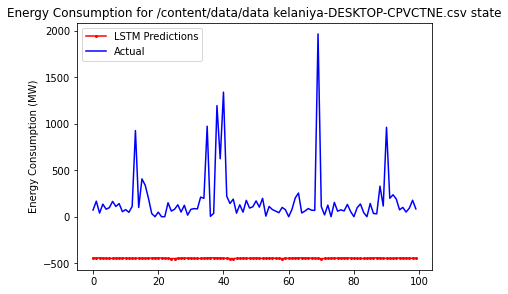

In [122]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

